# Reparameterizing the Weibull Accelerated Failure Time Model

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import statsmodels.api as sm
import theano.tensor as tt

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

## Dataset

The [previous example notebook on Bayesian parametric survival analysis](https://docs.pymc.io/notebooks/bayes_param_survival.html) introduced two different accelerated failure time (AFT) models: Weibull and log-linear. In this notebook, we present three different parameterizations of the Weibull AFT model.

The data set we'll use is the `flchain` R data set, which comes from a medical study investigating the effect of serum free light chain (FLC) on lifespan. Read the full documentation of the data by running:

`print(sm.datasets.get_rdataset(package='survival', dataname='flchain').__doc__)`.

In [3]:
# Fetch and clean data
data = (sm.datasets
          .get_rdataset(package="survival", dataname="flchain")
          .data
          .sample(500)  # Limit ourselves to 500 observations
          .reset_index(drop=True))

In [4]:
y = data.futime.values
censored = ~data["death"].values.astype(bool)

In [5]:
y[:5]

array([ 975, 2272,  138, 4262, 4928])

In [6]:
censored[:5]

array([False,  True, False,  True,  True])

## Using `pm.Potential`

We have an unique problem when modelling censored data. Strictly speaking, we don't have any _data_ for censored values: we only know the _number_ of values that were censored. How can we include this information in our model?

One way do this is by making use of `pm.Potential`. The [PyMC2 docs](https://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class) explain its usage very well. Essentially, declaring `pm.Potential('x', logp)` will add `logp` to the log-likelihood of the model.

## Parameterization 1

This parameterization is an intuitive, straightforward parameterization of the Weibull survival function. This is probably the first parameterization to come to one's mind.

In [7]:
def weibull_lccdf(x, alpha, beta):
    """ Log complementary cdf of Weibull distribution. """
    return -((x / beta) ** alpha)

In [8]:
with pm.Model() as model_1:
    alpha_sd = 10.0

    mu = pm.Normal("mu", mu=0, sigma=100)
    alpha_raw = pm.Normal("a0", mu=0, sigma=0.1)
    alpha = pm.Deterministic("alpha", tt.exp(alpha_sd * alpha_raw))
    beta = pm.Deterministic("beta", tt.exp(mu / alpha))

    y_obs = pm.Weibull("y_obs", alpha=alpha, beta=beta, observed=y[~censored])
    y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], alpha, beta))

In [9]:
with model_1:
    # Change init to avoid divergences
    data_1 = pm.sample(target_accept=0.9, init="adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbb93fa310>,
      dtype=object)

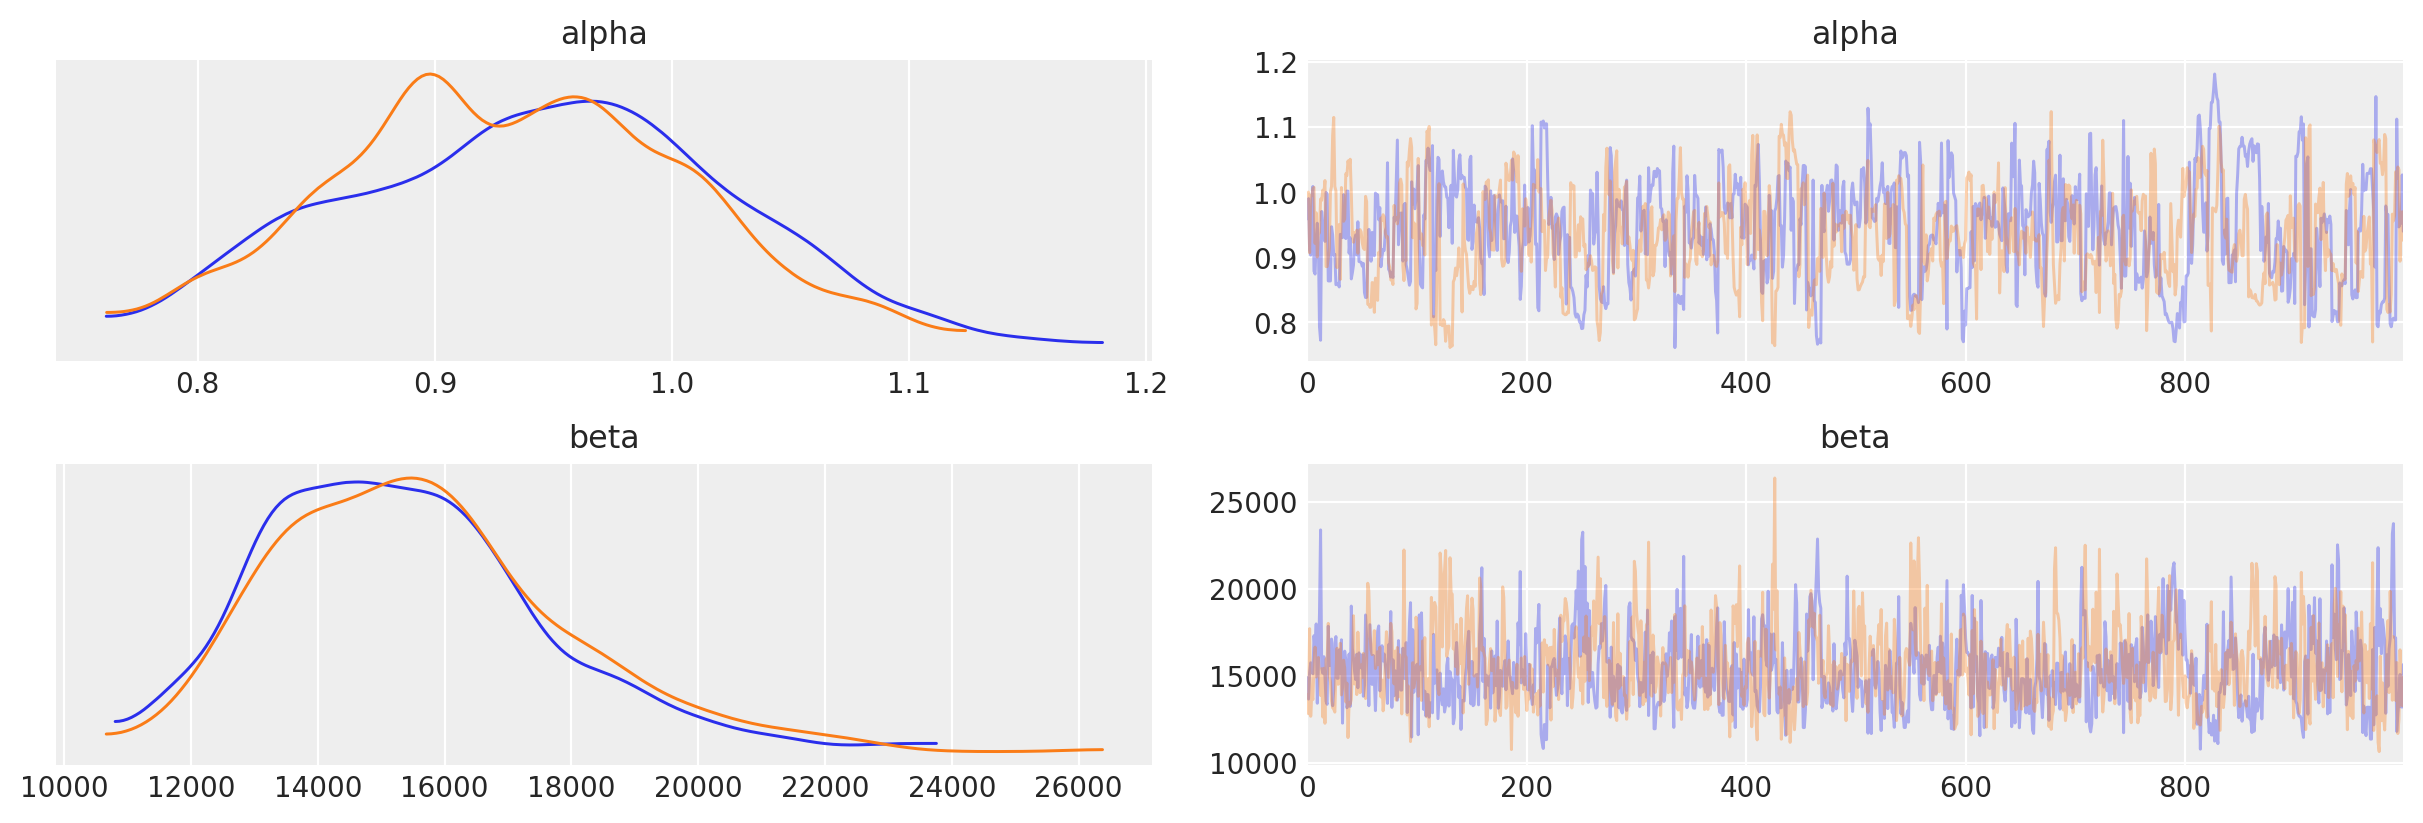

In [10]:
az.plot_trace(data_1, var_names=["alpha", "beta"])

In [11]:
az.summary(data_1, var_names=["alpha", "beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.94,0.08,0.79,1.07,0.0,0.00,286.27,284.96,284.54,275.03,1.01
beta,15498.35,2207.04,11575.41,19619.91,96.1,67.99,527.47,527.47,525.30,782.23,1.00


## Parameterization 2

Note that, confusingly, `alpha` is now called `r`, and `alpha` denotes a prior; we maintain this notation to stay faithful to the original implementation in Stan. In this parameterization, we still model the same parameters `alpha` (now `r`) and `beta`.

For more information, see [this Stan example model](https://github.com/stan-dev/example-models/blob/5e9c5055dcea78ad756a6fb9b3ff9a77a0a4c22b/bugs_examples/vol1/kidney/kidney.stan) and [the corresponding documentation](https://www.mrc-bsu.cam.ac.uk/wp-content/uploads/WinBUGS_Vol1.pdf).

In [12]:
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    r = pm.Gamma("r", alpha=1, beta=0.001, testval=0.25)
    beta = pm.Deterministic("beta", tt.exp(-alpha / r))

    y_obs = pm.Weibull("y_obs", alpha=r, beta=beta, observed=y[~censored])
    y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], r, beta))

In [13]:
with model_2:
    # Increase target_accept to avoid divergences
    data_2 = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbb48e1ee0>,
      dtype=object)

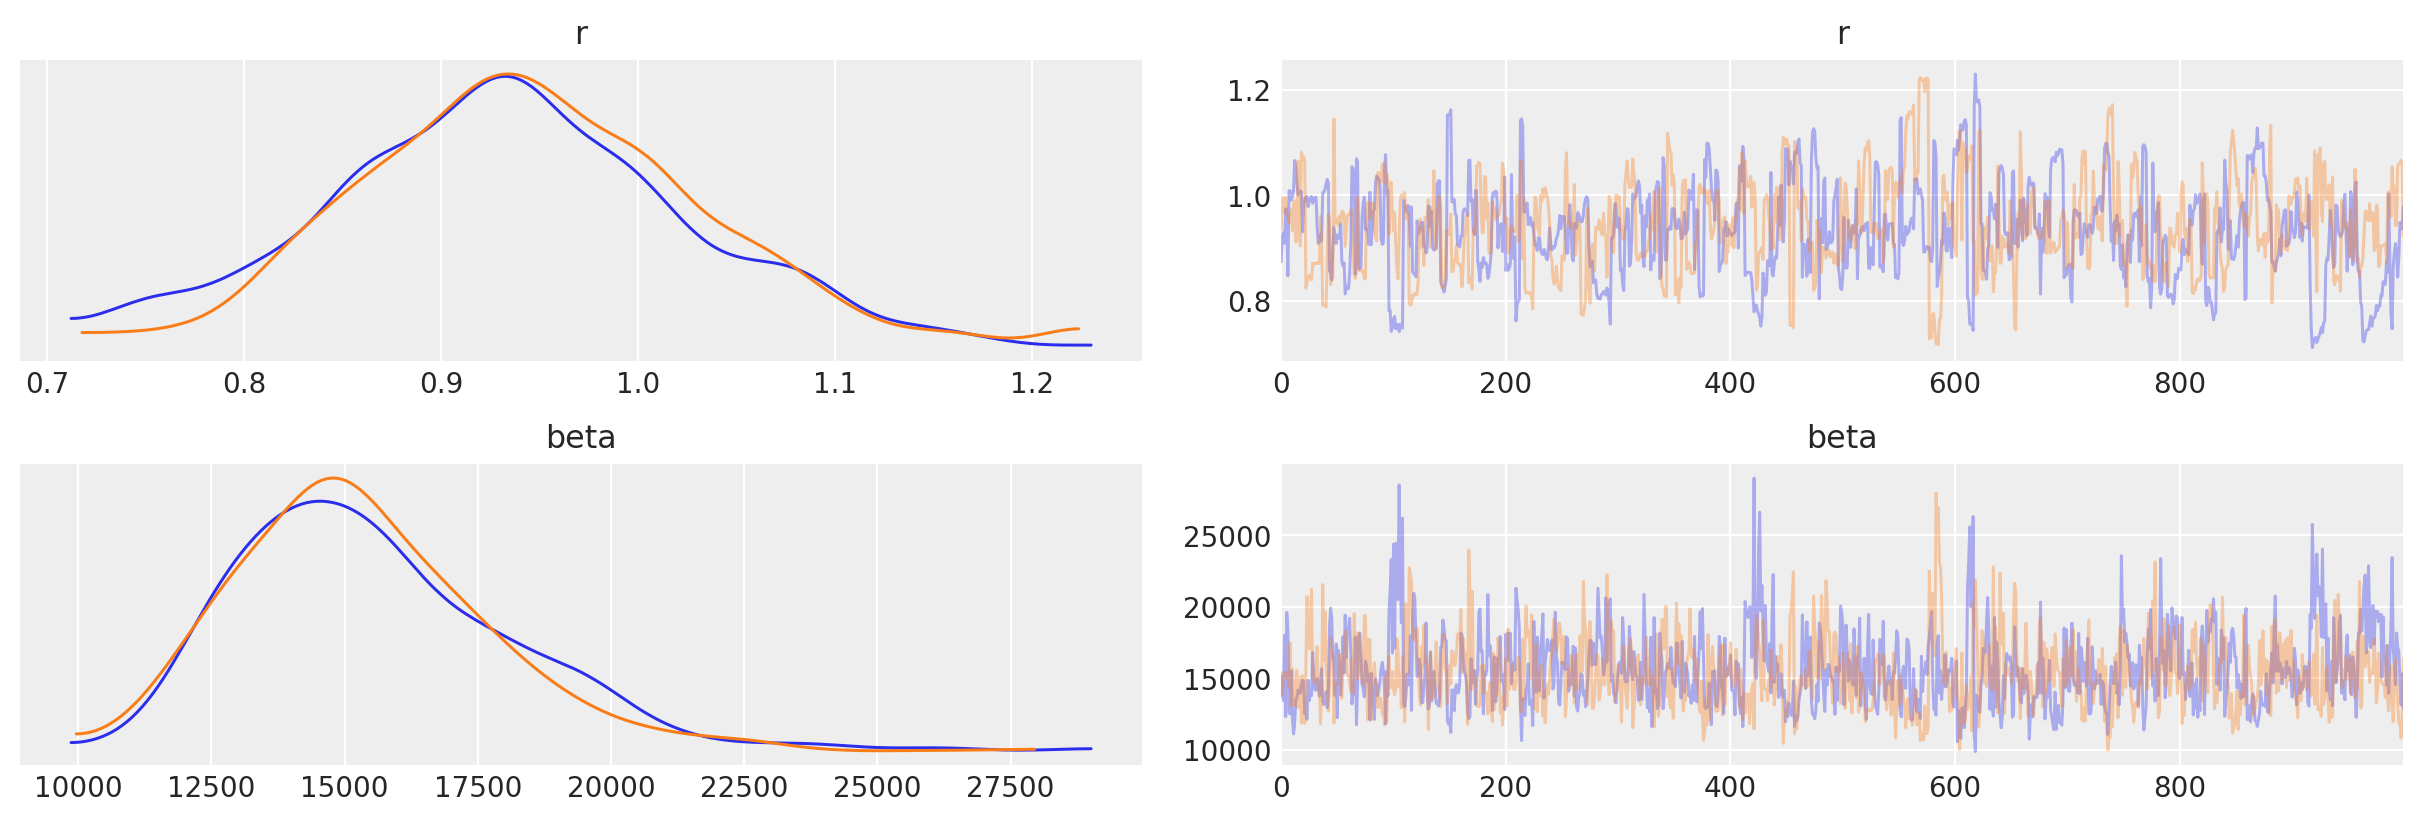

In [14]:
az.plot_trace(data_2, var_names=["r", "beta"])

In [15]:
az.summary(data_2, var_names=["r", "beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
r,0.94,0.09,0.77,1.11,0.01,0.00,276.97,271.14,285.89,235.46,1.01
beta,15498.45,2531.67,11402.90,20090.49,123.07,87.81,423.20,416.18,433.41,531.52,1.00


## Parameterization 3

In this parameterization, we model the log-linear error distribution with a Gumbel distribution instead of modelling the survival function directly. For more information, see [this blog post](http://austinrochford.com/posts/2017-10-02-bayes-param-survival.html).

In [16]:
logtime = np.log(y)


def gumbel_sf(y, mu, sigma):
    """ Gumbel survival function. """
    return 1.0 - tt.exp(-tt.exp(-(y - mu) / sigma))

In [17]:
with pm.Model() as model_3:
    s = pm.HalfNormal("s", tau=5.0)
    gamma = pm.Normal("gamma", mu=0, sigma=5)

    y_obs = pm.Gumbel("y_obs", mu=gamma, beta=s, observed=logtime[~censored])
    y_cens = pm.Potential("y_cens", gumbel_sf(y=logtime[censored], mu=gamma, sigma=s))

In [18]:
with model_3:
    # Change init to avoid divergences
    data_3 = pm.sample(init="adapt_diag", return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, s]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbbb574d280>,
      dtype=object)

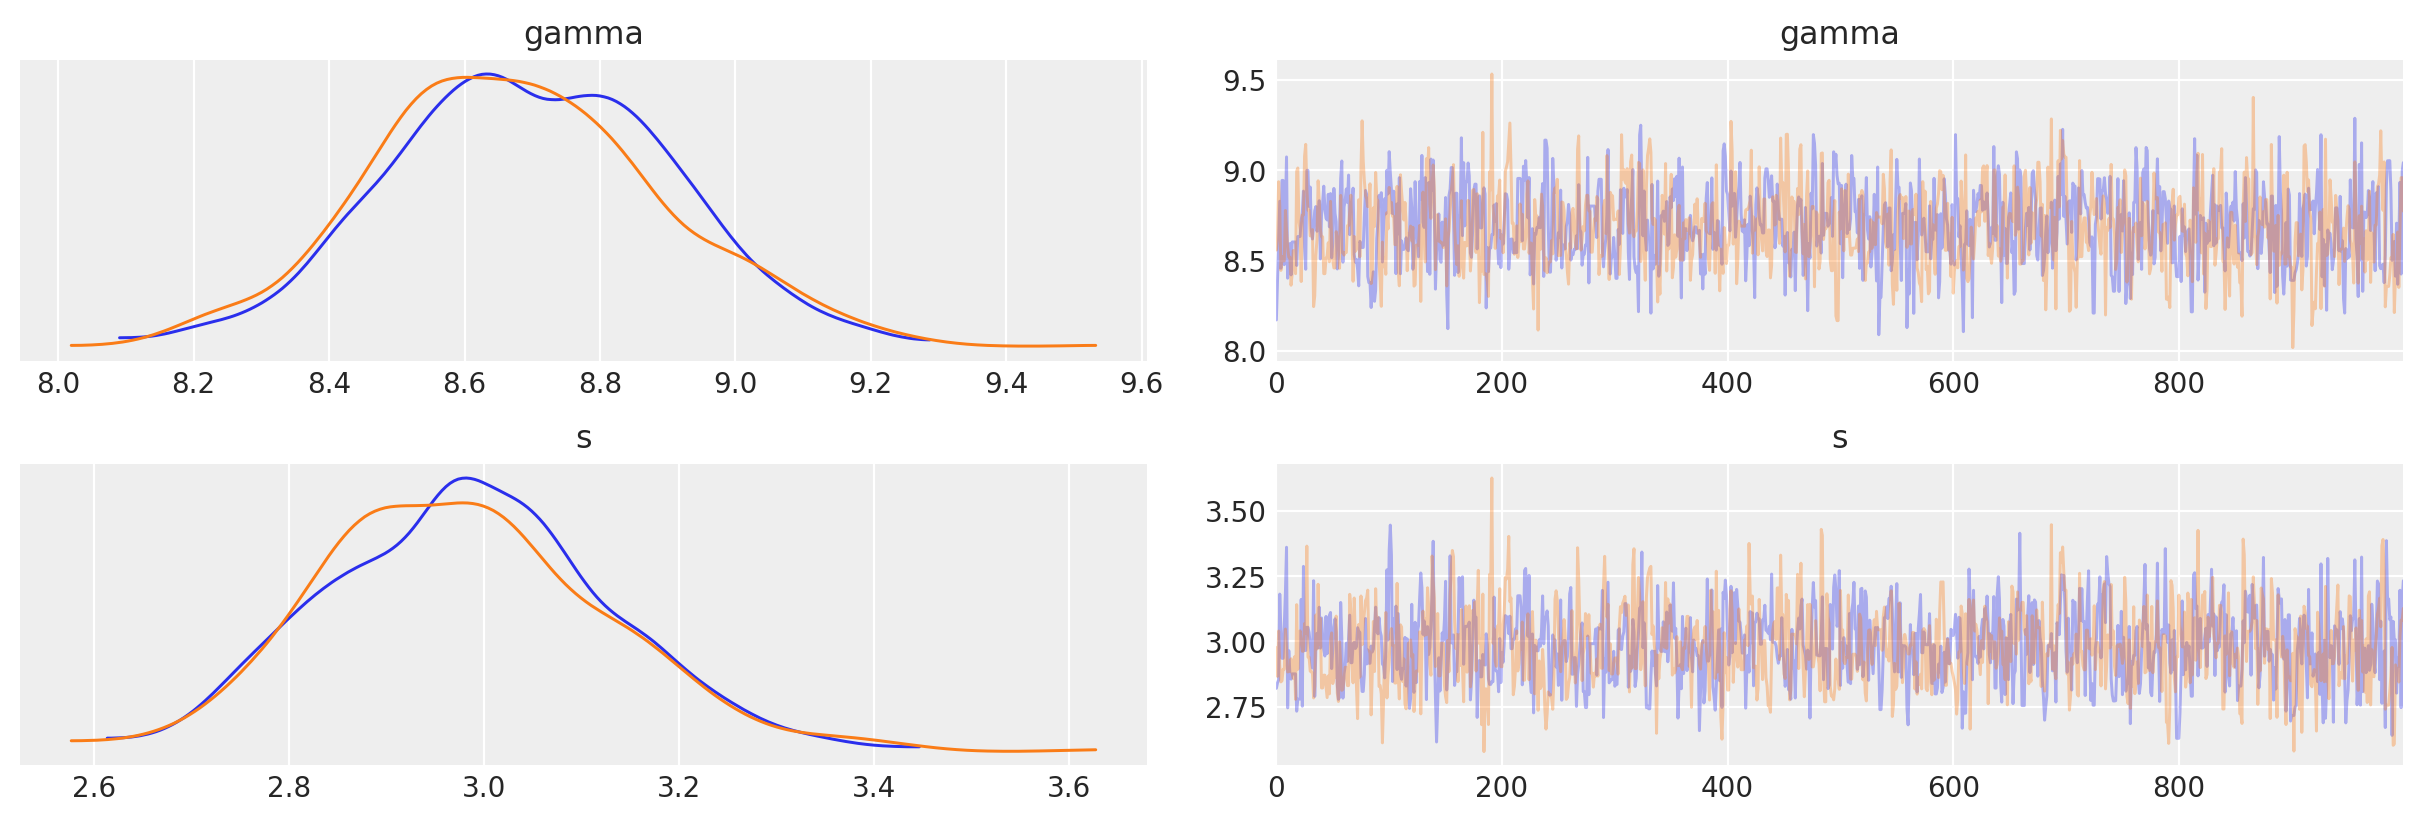

In [19]:
az.plot_trace(data_3)

In [20]:
az.summary(data_3, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gamma,8.69,0.21,8.29,9.08,0.01,0.0,984.06,984.06,985.32,1119.47,1.0
s,2.98,0.14,2.74,3.26,0.00,0.0,970.44,970.44,961.52,988.20,1.0


## Authors

- Originally collated by [Junpeng Lao](https://junpenglao.xyz/) on Apr 21, 2018. See original code [here](https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/65447fdb431c78b15fbeaef51b8c059f46c9e8d6/PyMC3QnA/discourse_1107.ipynb).
- Authored and ported to Jupyter notebook by [George Ho](https://eigenfoo.xyz/) on Jul 15, 2018.

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

statsmodels.api 0.11.1
pymc3           3.9.2
numpy           1.18.5
arviz           0.9.0
last updated: Thu Jul 23 2020 

CPython 3.8.3
IPython 7.16.1
watermark 2.0.2
